# ADE Code

## Advection

$\frac{\partial c}{\partial t}_x = -v\left(\frac{\partial c}{\partial x} \right)$

## Finite-Differences Solution

Advection step (Courant = 1):

$\Delta t = v*\Delta x$

Thus:

${c_x}^{t2} = {c_{x-1}}^{t1}$

We need to correct for Numerical dispersion if retardation occurs.

#### General Solution:

${c_x}^{t2} + {q_x}^{t2} = {c_{x-1}}^{t1} + {q_x}^{t1} + (1-\omega)*\left[ \frac{D_e \Delta t}{(\Delta x)^2} \left({c_{x-1}}^{t1}-2 {c_{x}}^{t1}+{c_{x+1}}^{t1}\right) -v \frac{\Delta t}{\Delta x}\left(\alpha {c_{x-1}}^{t1} +(1-2\alpha) {c_{x1}}^{t1} + \alpha {c_{x+1}}^{t1}\right)\right]+  
\omega*\left[ \frac{D_e \Delta t}{(\Delta x)^2} \left({c_{x-1}}^{t2}-2 {c_{x}}^{t2}+{c_{x+1}}^{t2}\right) -v \frac{\Delta t}{\Delta x}\left(\alpha {c_{x-1}}^{t2} +(1-2\alpha) {c_{x1}}^{t2} + \alpha {c_{x+1}}^{t2}\right)\right]$

## Model

#### libraries

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

#### Finite differences scheme:

We are applying our first advection model with a linear retardation scheme.

In [2]:
def iteration_advec(c: np.ndarray, c_in: np.float64):
    result = np.zeros(c.shape)
    
    #Advection:
    result = np.roll(c, 1)
    result[0] = c_in
    c_out = c[-1]
    
    return (result,c_out)

In [3]:
def iteration_crank(c,mixf, omega = 0.5):
    
    #Defining mixf terms for implicit and explicit schemes:
    mixfe = mixf*(1-omega)
    mixfi = mixf*omega
    # Calculating the Explicit-part:
    last_term = np.zeros(c.shape)
    # Threre is no fixed boundary, thus:
    last_term[0] = mixfe*c[1] + (1-mixfe)*c[0]
    
    #Update the middle_portion
    sliding_window = np.lib.stride_tricks.sliding_window_view(c, (3))
    kernel = np.array([mixfe, 1-2*mixfe, mixfe])
    last_term[1:-1] = np.dot(sliding_window,kernel)
    
    #Update the last cell:
    last_term[-1] = mixfe*c[-1-1] + (1-mixfe)*c[-1] 
    
    #Calculating the implicit part:
    
    c = last_term
    A = np.zeros((c.shape[0],c.shape[0]))

    #First row: initial_row:
    A[0,0],A[0,1] = [(1+mixfi),-mixfi]
    #Remaining middle rows:
    for i in range(1,A.shape[0]-1):
        A[i,i-1] = -mixfi
        A[i,i] = (1+2*mixfi)
        A[i,i+1] = -mixfi
    #last row:
    A[c.shape[0]-1,c.shape[0]-2],A[c.shape[0]-1,c.shape[0]-1] = [-mixfi,1+mixfi]
    
    #RHS of the system of linear equations, with explicit formulation:
    b = c
    
    #Solving the system of equations:
    result = scipy.linalg.solve(A,b)
    return result

#### Correction for linear sorption:

In [4]:
def sorp_corr(v,D, alpha_l, deltax,deltat, R, n_sub):
    alpha_mix = alpha_l-(deltax/2-v*deltat/(2*R))
    mixf = (D*deltat/(deltax**2)+alpha_mix*v*deltat/deltax**2)/n_sub
    return mixf

#### Sorption Iteration:

In [5]:
def sorb(c, q, R):
    total = c + q
    c = total/R
    q = total - c
    return (c,q)

### Model

In [6]:
def run_model(c_in, v, D, alpha_l, R, c0, q0, totx, deltax, max_time):
    

    #delta t for the advection:
    deltat = deltax/v
    
    print(f'number of cells: {x_steps}')
    print(f'deltax: {deltax}')
    print(f'deltat: {deltat}')
    
    
    #deltat for the diffusion/dispersion:
    maxdeltat_diff = deltax**2/(3*(D+alpha_l*v))
    n_sub = np.floor(deltat/maxdeltat_diff).astype(np.int32)
    deltat_diff = deltat/n_sub
    
    #Calculating diffusion/dispersion parameters:
    mixf = sorp_corr(v,D, alpha_l, deltax,deltat, R, n_sub)
    
    #Defining time_steps
    n_iter = np.ceil(max_time/deltat).astype(np.int32)
    timesteps = np.arange(deltat,(n_iter +1)*deltat,deltat)
    
    #Defining output:
    cell_history = np.zeros((n_iter,c0.shape[0]), dtype = np.float64)
    sorb_history = np.zeros((n_iter,q0.shape[0]), dtype = np.float64)
    outflow = np.zeros(n_iter)
    
    #Initial condition arrays:
    c = c0
    q = q0
    
    #Running model
    for i in range(n_iter):
        #Advect
        c,c_out = iteration_advec(c,c_in)
        
        #Sorb
        c,q = sorb(c, q, R)
        
        #Diffuse/Disperse
        for j in range(n_sub):
            c = iteration_crank(c, mixf)
        cell_history[i,:] = c
        sorb_history[i,:] = q
        outflow[i] = c_out
    
    return (cell_history,sorb_history, outflow, timesteps)
    

Adjusting model to changing boundary condition:

In [ ]:
def stress_period(c_in_arr, v, D, alpha_l, R, c0, q0, totx, deltax, t_arr, max_time):
    c0_s = c0
    q0_s = q0
    stress_periods_arrays = np.roll(t_arr)-t_arr
    
    for i in rang(c_in arr):
        cell_history,sorb_history, outflow, timesteps = 
            run_model(c_in, v, D, alpha_l, R, c0_s, q0_s, totx,deltax, stress_periods_arrays[i+1])
        c0_s = cell_history[-1,:].squeeze()
        q0_s = sorb_history[-1,:].squeeze()
        

#### Running Problem:

30 minutes pulse injection.
First compound does not undergo retardation.
Second compound does:  
    $K_d = 0.7 [L/kg],$  
    $\phi = 0.3 [-],$  
    $\rho_s = 2.65 [kg/L]$

#### input parameters

In [1]:
porosity = 0.3
alpha_l = 7*1e-2 #dispersivity [mm]
flow_rate = 100 #ml/min
flow_rate = flow_rate*1e-6/60 #m3/s
De = 1e-9 #[m2/s]
Kd = .7 #L/kg
c_in = 1 #mol/L
L = 1 #m column lengh
r = 0.05 #m column radius

In [2]:
c0 = 0
q0 = 0
v = flow_rate/(np.pi*r**2)/porosity
pore_volume_time = L/v
totx = 0.5
R = 1+(1-porosity)/porosity*Kd
max_time = 5*3600

NameError: name 'np' is not defined

In [ ]:
# Defining grid for the advection iteration:
#Delta x criteria:
try:
    maxdeltax = alpha_l*2*R/(R-1)/2 # half of the ideal criteria
except ZeroDivisionError:
    maxdeltax = totx/10
##Correcting the xcells
x_steps = np.ceil(totx/maxdeltax).astype(np.int32)
if x_steps < 10:
    x_steps = 10
#Delta x:
deltax = L/x_steps

In [9]:
c_out,c_outflow, timesteps = run_model(c_in, v, De, alpha_l, R, c0, q0, totx, max_time)

number of cells: 10
deltax: 0.05
deltat: 0.2945243112740431


In [10]:
cumulated_volume = flow_rate*timesteps

### Analytical solution:

In [11]:
def analytical(t,c_in,L,v,Dl,R):
    c = (c_in/2)*(scipy.special.erfc((L-v*t/R)/(np.sqrt(4*Dl*t/R)))+np.exp(v*L/Dl)*
                  scipy.special.erfc((L+v*t/R)/np.sqrt(4*Dl*t/R)))
    return c

In [12]:
c_out_ana = np.zeros(timesteps.shape)
Dl = De+v*alpha_l
for i in range(timesteps.shape[0]):
    c_out_ana[i] = analytical(timesteps[i],c_in,totx,v,Dl,R) 
    

In [13]:
analytical(timesteps[3],c_in,totx,v,Dl,R) 

1.716690920152104e-12

In [14]:
pore_flushes = cumulated_volume/pore_volume
pore_flushes[::30]

array([ 0.03,  0.93,  1.83,  2.73,  3.63,  4.53,  5.43,  6.33,  7.23,
        8.13,  9.03,  9.93, 10.83, 11.73, 12.63, 13.53, 14.43])

#### Plotting and comparing solutions:

Text(0, 0.5, '[y-HCH] [$\\mu g/L$]')

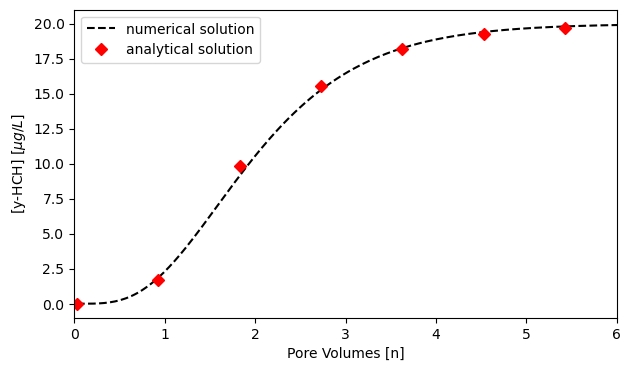

In [21]:
fig = plt.figure(figsize = (7,4))
ax = fig.add_subplot(111)
ax.plot(pore_flushes,c_outflow,'--k', label = 'numerical solution')
ax.plot(pore_flushes[::30],c_out_ana[::30], 'Dr', label = 'analytical solution')
ax.set_xlim([0,6])
ax.legend()
ax.set_xlabel('Pore Volumes [n]')
ax.set_ylabel(r'[y-HCH] [$\mu g/L$]')